In [6]:
import os
import re
import cv2
import numpy as np
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

In [ ]:
!unzip "/content/frames.zip" -d "/content/frames"

Archive:  /content/frames.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of /content/frames.zip or
        /content/frames.zip.zip, and cannot find /content/frames.zip.ZIP, period.


In [ ]:
! wget https://drive.google.com/uc?id=1e4cc4zFFna3Owyym6aq7ZXoquHA2l95O&export=download

--2021-01-17 09:41:17--  https://drive.google.com/uc?id=1e4cc4zFFna3Owyym6aq7ZXoquHA2l95O
Resolving drive.google.com (drive.google.com)... 74.125.195.139, 74.125.195.102, 74.125.195.101, ...
Connecting to drive.google.com (drive.google.com)|74.125.195.139|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘uc?id=1e4cc4zFFna3Owyym6aq7ZXoquHA2l95O’

uc?id=1e4cc4zFFna3O     [ <=>                ]   3.15K  --.-KB/s    in 0s      

2021-01-17 09:41:17 (37.1 MB/s) - ‘uc?id=1e4cc4zFFna3Owyym6aq7ZXoquHA2l95O’ saved [3221]



In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
path = "/content/drive/MyDrive/frames/"

In [17]:
# get file names of frames
col_frames = os.listdir(path)
col_frames

['0.png', '1.png', '2.png', '3.png', '4.png', '5.png', '7.png', '6.png']

In [18]:
# load frames
col_images=[]
for i in tqdm_notebook(col_frames):
    img = cv2.imread(path+i)
    col_images.append(img)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [19]:
np.array(col_images).shape

(8, 270, 480, 3)

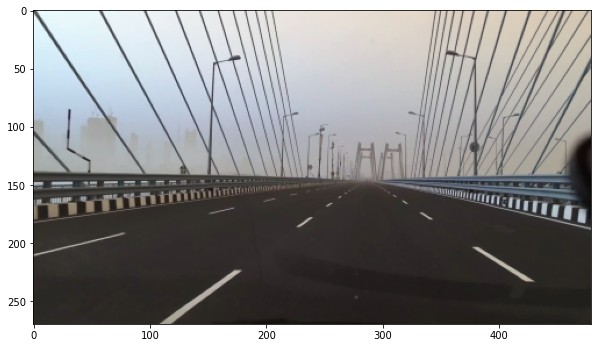

In [20]:
# specify frame index
idx = 4

# plot frame
plt.figure(figsize=(10,10))
plt.imshow(col_images[idx])
plt.show()

In [36]:
# Mask Creation
# create a zero array
stencil = np.zeros_like(col_images[idx][:,:,0])

# specify coordinates of the polygon
polygon = np.array([[100,270], [250,150], [330,160], [480,270]])

# fill polygon with ones
cv2.fillConvexPoly(stencil, polygon, 1)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 1, 1, 1]], dtype=uint8)

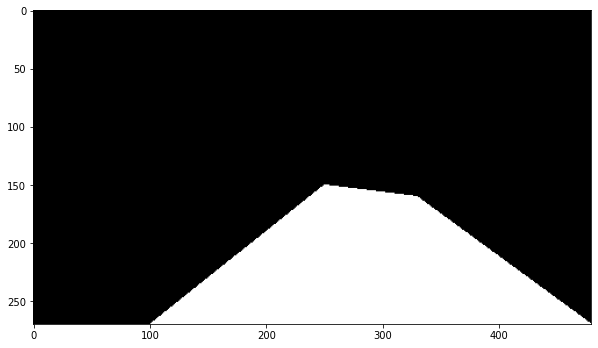

In [37]:
# plot polygon
plt.figure(figsize=(10,10))
plt.imshow(stencil, cmap= "gray")
plt.show()

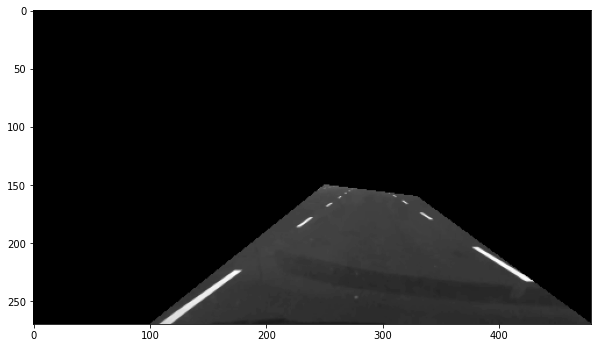

In [38]:
# apply polygon as a mask on the frame
img = cv2.bitwise_and(col_images[idx][:,:,0], col_images[idx][:,:,0], mask=stencil)

# plot masked frame
plt.figure(figsize=(10,10))
plt.imshow(img, cmap= "gray")
plt.show()

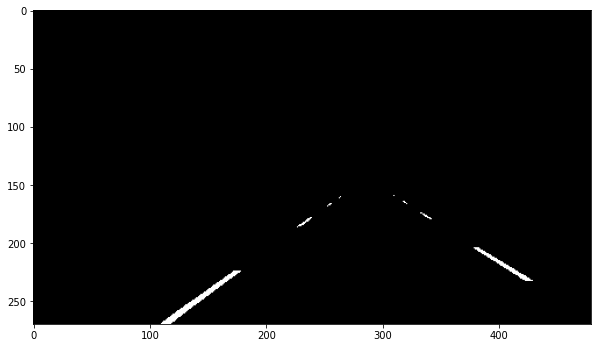

In [39]:
# apply image thresholding
ret, thresh = cv2.threshold(img, 130, 145, cv2.THRESH_BINARY)

# plot image
plt.figure(figsize=(10,10))
plt.imshow(thresh, cmap= "gray")
plt.show()

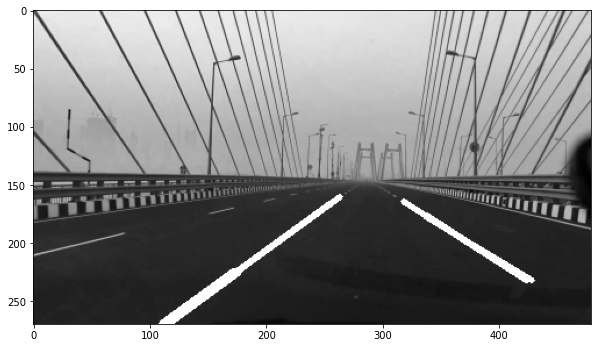

In [43]:
# Line Detection
lines = cv2.HoughLinesP(thresh, 1, np.pi/180, 30, maxLineGap=200)

# create a copy of the original frame
dmy = col_images[idx][:,:,0].copy()

# draw Hough lines
for line in lines:
  x1, y1, x2, y2 = line[0]
  cv2.line(dmy, (x1, y1), (x2, y2), (255, 0, 0), 3)

# plot frame
plt.figure(figsize=(10,10))
plt.imshow(dmy, cmap = "gray")
plt.show()

In [45]:
# For all frames now - main script
cnt = 0

for img in tqdm_notebook(col_images):
  
  # apply frame mask
  masked = cv2.bitwise_and(img[:,:,0], img[:,:,0], mask=stencil)
  
  # apply image thresholding
  ret, thresh = cv2.threshold(masked, 130, 145, cv2.THRESH_BINARY)

  # apply Hough Line Transformation
  lines = cv2.HoughLinesP(thresh, 1, np.pi/180, 30, maxLineGap=200)
  dmy = img.copy()
  
  # Plot detected lines
  try:
    for line in lines:
      x1, y1, x2, y2 = line[0]
      cv2.line(dmy, (x1, y1), (x2, y2), (255, 0, 0), 3)
  
    cv2.imwrite(path + 'detected/'+str(cnt)+'.png',dmy)
  
  except TypeError: 
    cv2.imwrite(path + 'detected/'+str(cnt)+'.png',img)

  cnt+= 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [46]:
# Output video preparation
# input frames path
pathIn= path + 'detected/'

# output path to save the video
pathOut = path + 'roads_v2.mp4'

# specify frames per second
fps = 30.0

In [47]:
from os.path import isfile, join

# get file names of the frames
files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]

frame_list = []

for i in tqdm_notebook(range(len(files))):
    filename=pathIn + files[i]
    #reading each files
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    
    #inserting the frames into an image array
    frame_list.append(img)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [49]:
# write the video
out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'DIVX'), fps, size)

for i in range(len(frame_list)):
    # writing to a image array
    out.write(frame_list[i])

out.release()